In [116]:
!pip install pandas seaborn tabulate
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import matplotlib.patches as mpatches
import os
from IPython.core.display import HTML

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams["font.sans-serif"] = ["Palatino"]

palette = ['#648FFF', '#DC267F', '#FFB000', '#785EF0', '#000000']
sns.set_palette(palette)

pd.options.display.max_rows = 500
pd.set_option('display.max_colwidth', None)


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [117]:
df = None
kinds = ["machine", "math"]

prover_names = {
    "Z3_4_8_5": "Z3 4.8.5",
    "Z3_4_8_9": "Z3 4.8.9",
    "Z3_4_8_17": "Z3 4.8.17",
    "CVC4_1_8": "CVC4 1.8",
    "CVC5_1_1_2": "CVC5 1.1.2",
    "Gappa_1_4_0": "Gappa 1.4.0",
    "Alt-Ergo_2_5_4": "Alt-Ergo 2.5.4"
}

provers = list(prover_names.keys())
print(provers)

for kind in kinds:
    for prover in provers:
        path = "../results_" + kind + "_" + prover + ".csv"
        
        if not os.path.isfile(path):
            path = "../results_machine_Z3_4_8_9.csv"
            csv = pd.read_csv(path)
            csv.loc[:, "result"] = "NOT RAN"
        else:
            csv = pd.read_csv(path)
        
        # ArrayReverse test is wrong, exclude it 
        csv = csv.loc[~csv.goal.str.contains(".ArrayReverse.", regex=False) , :]
        csv["result"] = csv["result"].apply(lambda c: int(c == "Valid"))
        
        csv = csv.rename(columns={
            'result': 'result_' + kind + "_" + prover,
            'time': 'time_' + kind + "_" + prover,
            'steps': 'steps_' + kind + "_" + prover,
        })
        
        if df is None:
            df = csv
        else:
            df = df.merge(csv, how='outer', on=['file', 'kind', 'goal'])


df_categories = pd.read_csv('../categories.csv')
df_categories.goal = df_categories.goal.apply(lambda x: x.replace("[", "R").replace(" ", "'020"))


df_stats = pd.read_csv('../stats.csv')
df_stats.goal = df_stats.goal.apply(lambda x: x.replace("[", "R").replace(" ", "'020"))

df = df_stats.join(df.set_index(["file", "goal"]), on=["file", "goal"], how="right")
df = df_categories.join(df.set_index(["file", "goal"]), on=["file", "goal"], how="right")
df

['Z3_4_8_5', 'Z3_4_8_9', 'Z3_4_8_17', 'CVC4_1_8', 'CVC5_1_1_2', 'Gappa_1_4_0', 'Alt-Ergo_2_5_4']


,file,goal,category1,category2,category3,heap_count,missing_inv_count,kind,result_machine_Z3_4_8_5,time_machine_Z3_4_8_5,...,steps_math_CVC4_1_8,result_math_CVC5_1_1_2,time_math_CVC5_1_1_2,steps_math_CVC5_1_1_2,result_math_Gappa_1_4_0,time_math_Gappa_1_4_0,steps_math_Gappa_1_4_0,result_math_Alt-Ergo_2_5_4,time_math_Alt-Ergo_2_5_4,steps_math_Alt-Ergo_2_5_4
719,test-java-17/src/main/java/byteback/test/switchexpression/Output/Basic.java.tmp.mlcfg,byteback.test.switchexpression.Basic.switchInteger()V,branch,arithmetic,comparison,2,0,cfg,1,0.04,...,51519,1,0.08,40500,0,0.0,NaN,1,0.03,189
717,test-java-17/src/main/java/byteback/test/switchexpression/Output/Basic.java.tmp.mlcfg,byteback.test.switchexpression.Basic.<clinit>()V,spec,NaN,NaN,1,0,cfg,1,0.04,...,49920,1,0.07,39288,0,0.0,NaN,1,0.03,188
718,test-java-17/src/main/java/byteback/test/switchexpression/Output/Basic.java.tmp.mlcfg,byteback.test.switchexpression.Basic.<init>()V,spec,NaN,NaN,0,0,cfg,1,0.04,...,39648,1,0.06,33873,0,0.0,NaN,1,0.02,190
720,test-java-17/src/main/java/byteback/test/switchexpression/Output/Basic.java.tmp.mlcfg,byteback.test.switchexpression.Basic.switchYieldInteger()V,branch,arithmetic,comparison,2,0,cfg,1,0.05,...,51519,1,0.08,40500,0,0.0,NaN,1,0.04,189
722,test-java-17/src/main/java/byteback/test/typeinference/Output/Basic.java.tmp.mlcfg,byteback.test.typeinference.Basic.inferPrimitives()V,references,comparison,NaN,0,0,cfg,1,0.03,...,34609,1,0.02,25289,1,0.0,NaN,1,0.01,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,test-kotlin-1.8.0/src/main/kotlin/byteback/test/controlflow/Output/Basic.kt.tmp.mlcfg,byteback.test.controlflow.Basic.emptyWhile(Z)V,loop,NaN,NaN,0,1,cfg,1,0.03,...,36987,1,0.04,32735,0,0.0,NaN,1,0.02,62
108,test-kotlin-1.8.0/src/main/kotlin/byteback/test/controlflow/Output/Basic.kt.tmp.mlcfg,byteback.test.controlflow.Basic.emptyDoWhile(Z)V,loop,NaN,NaN,0,1,cfg,1,0.03,...,36987,1,0.04,32735,0,0.0,NaN,1,0.02,62
122,test-kotlin-1.8.0/src/main/kotlin/byteback/test/controlflow/Output/Basic.kt.tmp.mlcfg,byteback.test.controlflow.Basic.sum(II)I,loop,arithmetic,NaN,0,0,cfg,1,0.02,...,30528,1,0.02,15392,1,0.0,NaN,1,0.01,52
105,test-kotlin-1.8.0/src/main/kotlin/byteback/test/controlflow/Output/Basic.kt.tmp.mlcfg,byteback.test.controlflow.Basic.empty()V,spec,NaN,NaN,0,0,cfg,1,0.02,...,30528,1,0.02,15392,1,0.0,NaN,1,0.01,52


In [146]:
df_cats = df.loc[:, ["file", "category1", "category2", "category3"]].drop_duplicates()
df_cats['category'] = df_cats[['category1', 'category2', 'category3']].values.tolist()
df_cats['category'] = df_cats['category'].apply(lambda x: [e for e in x if type(e) == str])
del df_cats['category1']
del df_cats['category2']
del df_cats['category3']
df_cats = df_cats.groupby('file').sum()
df_cats['category'] = df_cats['category'].apply(lambda x: ",".join([f"*{e}*" for e in sorted(set(x))]))
df_cats

,category
file,
test-java-17/src/main/java/byteback/test/examples/Output/ReadResource.java.tmp.mlcfg,"*arrays*,*comparison*,*exceptions*,*loop*,*spec*,*state*"
test-java-17/src/main/java/byteback/test/examples/Output/Summary.java.tmp.mlcfg,"*arithmetic*,*arrays*,*comparison*,*loop*,*quantifier*,*spec*"
test-java-17/src/main/java/byteback/test/exceptions/Output/TryWithResources.java.tmp.mlcfg,"*exceptions*,*spec*,*state*"
test-java-17/src/main/java/byteback/test/patternmatching/Output/Basic.java.tmp.mlcfg,"*arrays*,*instanceof*,*spec*"
test-java-17/src/main/java/byteback/test/switchexpression/Output/Basic.java.tmp.mlcfg,"*arithmetic*,*branch*,*comparison*,*spec*"
test-java-17/src/main/java/byteback/test/typeinference/Output/Basic.java.tmp.mlcfg,"*comparison*,*references*,*spec*"
test-java-8/src/main/java/byteback/test/algorithm/Output/BinarySearch.java.tmp.mlcfg,"*arrays*,*comparison*,*loop*,*spec*"
test-java-8/src/main/java/byteback/test/algorithm/Output/DoubleInsertionSort.java.tmp.mlcfg,"*arrays*,*comparison*,*quantifier*,*spec*"
test-java-8/src/main/java/byteback/test/algorithm/Output/DoubleMax.java.tmp.mlcfg,"*arrays*,*comparison*,*quantifier*,*references*,*spec*"


In [160]:
df_programs = pd.read_csv('/Users/maggicl/git/byteback/byteback-test/experiments.csv')

def to_file_path(f):
    s = f.split(".")
    return "/".join(s[:-1]) + "/Output/" + s[-1]

def not_of_category(df, category):
    return (df["category1"].fillna("") != category) & (df["category2"].fillna("") != category) & (df["category3"].fillna("") != category)

df_programs['path'] = 'test-' + df_programs['folder'] + '/src/main/' + df_programs['folder'].apply(lambda x: x.split('-')[0]) + \
    '/byteback/test/' + df_programs['Package'].apply(to_file_path) + '.' + \
    df_programs['folder'].apply(lambda x: "java" if x.startswith("java-") else "scala" if x.startswith("scala-") else "kt") + ".tmp.mlcfg"

def loc_why(path):
    with open("/Users/maggicl/git/byteback/byteback-test/" + path) as f:
        return len(f.readlines())

def loc(path):
    with open("/Users/maggicl/git/byteback/byteback-test/" + path.replace("/Output", "").replace(".tmp.mlcfg", "")) as f:
        return len(f.readlines())

df_programs['loc'] = df_programs['path'].apply(loc)
df_programs['loc_why'] = df_programs['path'].apply(loc_why)

df_programs = df_programs.set_index('path')

df_total_result_machine = pd.DataFrame(df.filter(regex="^result_machine_").sum(axis=1) > 0, columns=["total_machine"]).join(df.loc[:, ["file"]]).groupby("file").all()
df_total_result_math = pd.DataFrame(df.filter(regex="^result_math_").sum(axis=1) > 0, columns=["total_math"]).join(df.loc[:, ["file"]]).groupby("file").all()
display(not_of_category(df, "spec").filter(regex="^result_machine_"))

df_total_result_machine_any = pd.DataFrame(df[not_of_category(df, "spec")].filter(regex="^result_machine_").sum(axis=1) > 0, columns=["any_machine"]).join(df.loc[:, ["file"]]).groupby("file").any()
df_total_result_math_any = pd.DataFrame(df[not_of_category(df, "spec")].filter(regex="^result_math_").sum(axis=1) > 0, columns=["any_math"]).join(df.loc[:, ["file"]]).groupby("file").any()
df_programs = df_programs.join(df_total_result_machine).join(df_total_result_math).join(df_total_result_machine_any).join(df_total_result_math_any)

df_programs["total_machine"] = df_programs["total_machine"] + df_programs["any_machine"] 
df_programs["total_math"] = df_programs["total_math"] + df_programs["any_math"] 

cols = ["total_machine", "total_math"]
for x in cols:
    df_programs[x] = df_programs[x].apply(lambda x: "V" if x == 2 else "~" if x == 1 else " ")

df_programs = df_programs.loc[:, ["Description", "Language", "loc", "loc_why", "total_machine", "total_math"]] \
      .sort_values(["Language", "Description"], ascending=True) \
      .join(df_cats) \
      .fillna("") \
      .loc[:, ["Description", "category", "Language", "loc", "loc_why", "total_machine", "total_math"]] \
     
print(df_programs.groupby("total_machine").count())
print(df_programs.groupby("total_math").count())

print(df_programs.to_markdown(index=False).replace("  ", "").replace("| ", "|").replace(" |", "|"))

Series([], dtype: bool)

               Description  category  Language  loc  loc_why  total_math
total_machine                                                           
                        11        11        11   11       11          11
V                       22        22        22   22       22          22
~                       37        37        37   37       37          37
            Description  category  Language  loc  loc_why  total_machine
total_math                                                              
                     11        11        11   11       11             11
V                    21        21        21   21       21             21
~                    38        38        38   38       38             38
|Description|category|Language|loc|loc_why|total_machine|total_math|
|:-------------------------------------------|:--------------------------------------------------------------|:-------------|------:|----------:|:----------------|:-------------|
|Array Operations|*arr

In [119]:
print(df.loc[df.missing_inv_count > 0, ["category1", "category2", "category3", "missing_inv_count"]].fillna("") \
    .groupby(["category1", "category2", "category3"]).count().reset_index().to_markdown(index=False))

print(df.loc[df.missing_inv_count > 0, ["category1", "category2", "category3", "missing_inv_count"]].fillna("") \
    .groupby(["category1", "category2", "category3"]).sum().reset_index().to_markdown(index=False))

df.loc[(df.missing_inv_count > 0) & (df.category1 != "stdlib")]

| category1   | category2   | category3   |   missing_inv_count |
|:------------|:------------|:------------|--------------------:|
| exceptions  |             |             |                   9 |
| exceptions  | loop        |             |                   3 |
| exceptions  | state       |             |                   9 |
| loop        |             |             |                   8 |
| stdlib      |             |             |                  46 |
| category1   | category2   | category3   |   missing_inv_count |
|:------------|:------------|:------------|--------------------:|
| exceptions  |             |             |                   9 |
| exceptions  | loop        |             |                   3 |
| exceptions  | state       |             |                  15 |
| loop        |             |             |                   8 |
| stdlib      |             |             |                  63 |


,file,goal,category1,category2,category3,heap_count,missing_inv_count,kind,result_machine_Z3_4_8_5,time_machine_Z3_4_8_5,...,steps_math_CVC4_1_8,result_math_CVC5_1_1_2,time_math_CVC5_1_1_2,steps_math_CVC5_1_1_2,result_math_Gappa_1_4_0,time_math_Gappa_1_4_0,steps_math_Gappa_1_4_0,result_math_Alt-Ergo_2_5_4,time_math_Alt-Ergo_2_5_4,steps_math_Alt-Ergo_2_5_4
312,test-java-8/src/main/java/byteback/test/exceptions/Output/TryFinally.java.tmp.mlcfg,byteback.test.exceptions.TryFinally.finallyOverrides2NestedFinally()I,exceptions,NaN,NaN,3,1,cfg,0,10.00,...,9071654,0,10.00,981342,0,0.00,NaN,0,10.00,76327
318,test-java-8/src/main/java/byteback/test/exceptions/Output/TryFinally.java.tmp.mlcfg,byteback.test.exceptions.TryFinally.finallyOverridesThrows()I,exceptions,NaN,NaN,3,1,cfg,0,10.00,...,9071654,0,10.00,1021583,0,0.00,NaN,0,10.00,76154
309,test-java-8/src/main/java/byteback/test/exceptions/Output/TryFinally.java.tmp.mlcfg,byteback.test.exceptions.TryFinally.finallyOverrides1NestedFinally()I,exceptions,NaN,NaN,3,1,cfg,0,10.00,...,9073786,0,10.00,998548,0,0.00,NaN,0,10.00,76367
337,test-java-8/src/main/java/byteback/test/exceptions/Output/TryWithResources.java.tmp.mlcfg,byteback.test.exceptions.TryWithResources.tryWithResourcesOn2Resources()V,exceptions,state,NaN,20,1,cfg,0,10.00,...,6797825,0,10.00,1202772,0,0.01,NaN,0,10.00,87745
338,test-java-8/src/main/java/byteback/test/exceptions/Output/TryWithResources.java.tmp.mlcfg,byteback.test.exceptions.TryWithResources.tryWithResourcesOn3Resources()V,exceptions,state,NaN,36,1,cfg,0,10.00,...,5332417,0,10.00,1121171,0,0.01,NaN,0,10.00,87590
330,test-java-8/src/main/java/byteback/test/exceptions/Output/TryWithResources.java.tmp.mlcfg,byteback.test.exceptions.TryWithResources.nested3TryWithResourcesOn3Resources()V,exceptions,state,NaN,37,3,cfg,0,10.00,...,6998609,0,10.00,958449,0,1.16,NaN,0,10.00,85549
332,test-java-8/src/main/java/byteback/test/exceptions/Output/TryWithResources.java.tmp.mlcfg,byteback.test.exceptions.TryWithResources.throwingTryWithResourcesClosesResource()V,exceptions,state,NaN,11,1,cfg,0,10.00,...,7004646,0,10.00,1223912,0,0.01,NaN,0,10.00,88104
331,test-java-8/src/main/java/byteback/test/exceptions/Output/TryWithResources.java.tmp.mlcfg,byteback.test.exceptions.TryWithResources.nested3TryWithResourcesOnSingleResource()V,exceptions,state,NaN,35,3,cfg,0,10.00,...,8546241,0,10.00,1538977,0,0.05,NaN,0,10.00,84645
329,test-java-8/src/main/java/byteback/test/exceptions/Output/TryWithResources.java.tmp.mlcfg,byteback.test.exceptions.TryWithResources.nested2TryWithResourcesOnSingleResource()V,exceptions,state,NaN,14,2,cfg,0,10.00,...,8472238,0,10.00,1139684,0,0.02,NaN,0,10.00,84887
335,test-java-8/src/main/java/byteback/test/exceptions/Output/TryWithResources.java.tmp.mlcfg,byteback.test.exceptions.TryWithResources.tryWithResourcesFinallyClosesResource()V,exceptions,state,NaN,8,1,cfg,0,10.00,...,10140926,0,10.00,893181,0,0.01,NaN,0,10.00,86534


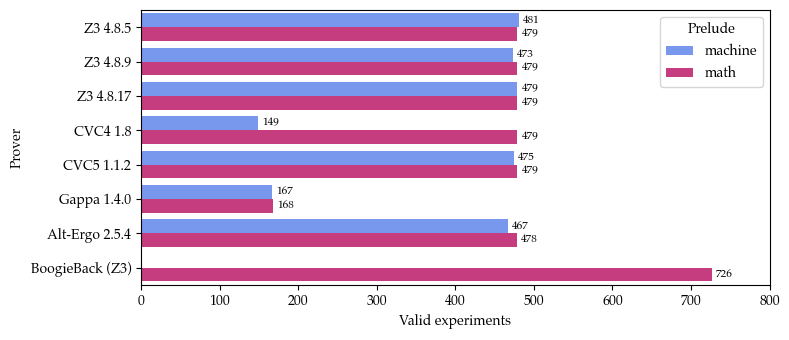

In [4]:
def results_main_plot(df, ax, limit):
    df_sum = pd.DataFrame(df.filter(regex=r'^result_').reset_index(drop=True).sum(), columns=["Valid experiments"])
    df_sum["Prelude"] = df_sum.index.map(lambda x: x.replace("result_", "").split("_", 1)[0])
    df_sum["Prover"] = df_sum.index.map(lambda x: x.replace("result_", "").split("_", 1)[1]
                                        .replace("_", " ", 1)
                                        .replace("cvc", "CVC")
                                        .replace("z3", "Z3")
                                        .replace("gappa", "Gappa")
                                        .replace("altergo", "Alt-Ergo")
                                        .replace("_", "."))
    #df_sum["version"] = df_sum.index.map(lambda x: x.replace("result_", "").split("_", 1)[2])
    df_sum.loc["total", ["Valid experiments", "Prelude", "Prover"]] = [len(df.index), "math", "BoogieBack (Z3)"]
    
    sns.barplot(data=df_sum, ax=ax, x="Valid experiments", y="Prover", hue="Prelude")
    ax.set_xlim([0, limit])
    for container in ax.containers:
        ax.bar_label(container, padding=3, fontsize=8)

fig, ax = plt.subplots(figsize=(8, 3.5))
results_main_plot(df, ax, 800)
fig.align_ylabels()
plt.tight_layout()
plt.savefig('/Users/maggicl/git/seminar/thesis/figures/06-analysis/results-main.pgf')
plt.show()

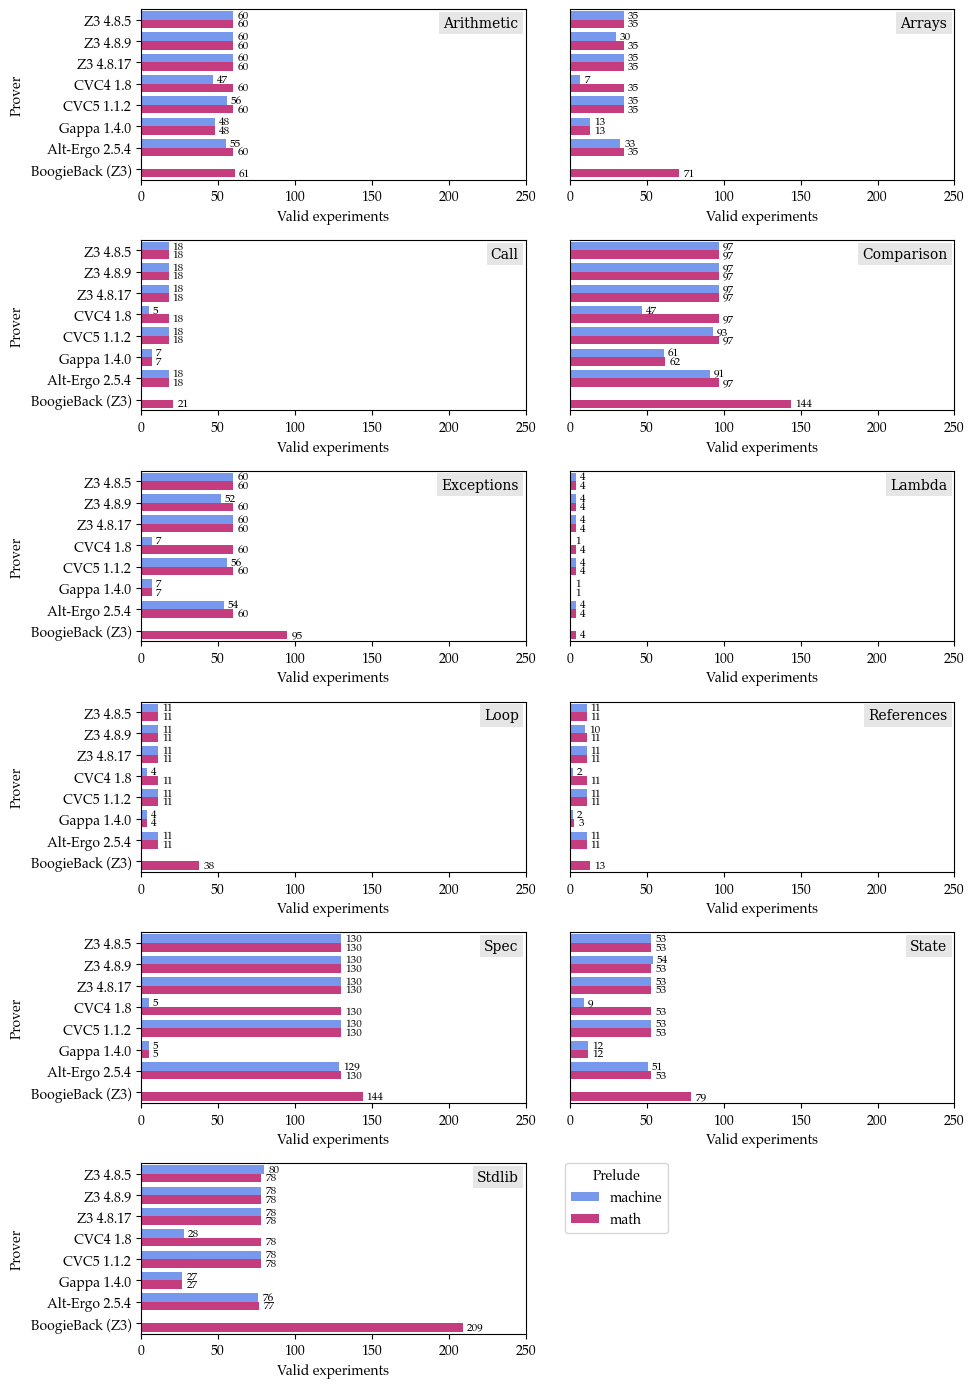

In [5]:
categories = ['arithmetic', 'arrays', 'call', 'comparison', 'exceptions', 'lambda', 'loop', 'references', 'spec', 'state', 'stdlib']

def of_category(df, category):
    return (df["category1"] == category) | (df["category2"] == category) | (df["category3"] == category)

fig = plt.figure(figsize=(10, 14))

old_ax = None

for i, cat in enumerate(categories):
    ax = fig.add_subplot(6,2,i + 1, sharey=old_ax)
    cat = categories[i]
    results_main_plot(df.loc[of_category(df, cat)], ax, 250)
    ax.get_legend().remove()
    old_ax = ax

    if i % 2 == 1:
        ax.get_yaxis().set_visible(False)

    ax.annotate(
        cat.capitalize(),
        xy=(0, 1), xycoords='axes fraction',
        xytext=(+27.2, -0.5), textcoords='offset fontsize',
        fontsize='medium', verticalalignment='top', horizontalalignment='right', fontfamily='serif',
        bbox=dict(facecolor='0.9', edgecolor='none', pad=3.0))
    
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes][0:1]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, bbox_to_anchor=(0.68, 0.17), title="Prelude")
fig.align_ylabels()
plt.tight_layout()
plt.savefig('/Users/maggicl/git/seminar/thesis/figures/06-analysis/results-categories.pgf')
plt.show()

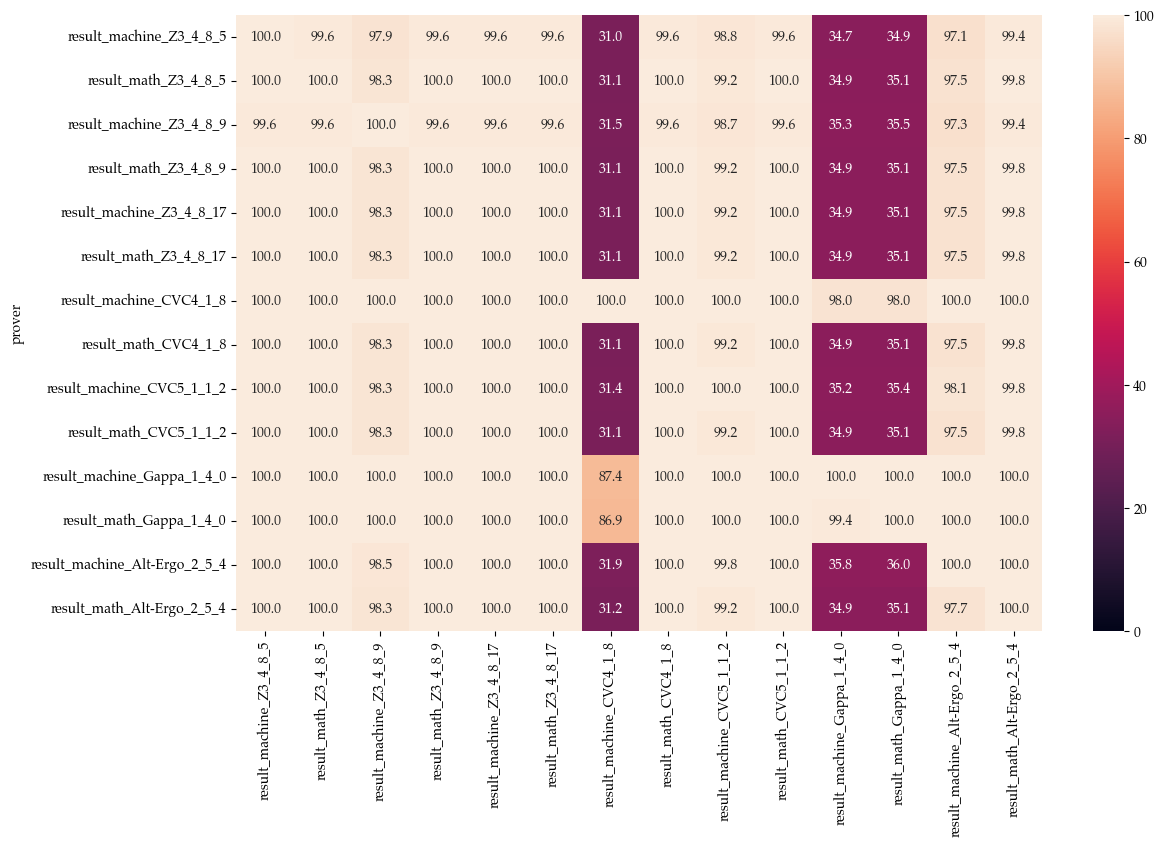

In [6]:
dfs = []

columns = [f"result_{kind}_{prover}" for prover in provers for kind in kinds]

for column in columns:
    tab = df.loc[df[column] == 1, columns].copy(deep=True)
    count = sum(df[column] == 1)
    tab["prover"] = column
    tab = tab.groupby(["prover"]).sum()
    tab = tab.apply(lambda r: r.apply(lambda c: 100 * c / count))
    dfs.append(tab)

plt.figure(1,(13,8))
df_all = pd.concat(dfs)

sns.heatmap(df_all, annot=True, fmt="2.1f", vmin=0, vmax=100)
plt.show()

/var/folders/84/pwxv9qyd68qfk56f26nwlpgm0000gp/T/ipykernel_2849/3686072486.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/84/pwxv9qyd68qfk56f26nwlpgm0000gp/T/ipykernel_2849/3686072486.py:80: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


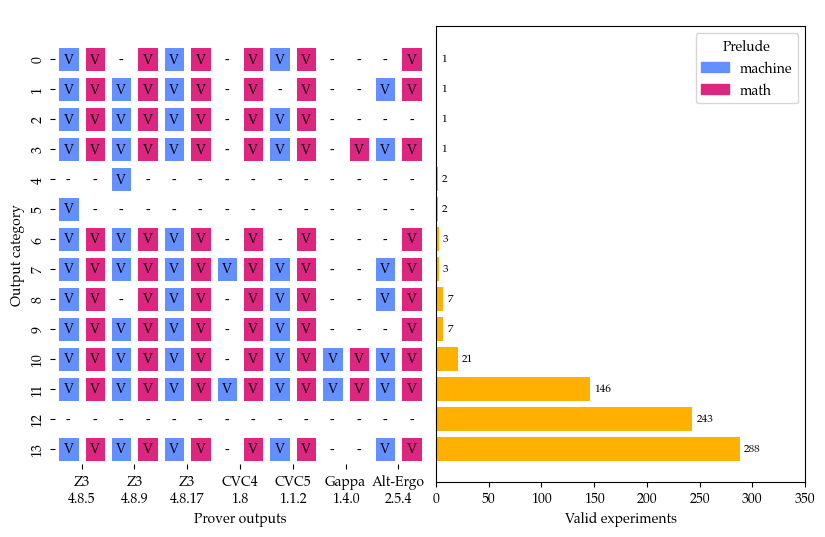

In [39]:
df_res = df.loc[:, columns] \
    .assign(count=1) \
    .groupby(columns).sum().reset_index() \
    .sort_values("count").reset_index(drop=True)

def to_name(col):
    if col.endswith("count"):
        return col
    
    col = col.replace("result_", "")
    col = col.split("_", 1)
    return prover_names[col[1]].replace(" ", "\n") # ({col[0]})"

df_res.loc[:, [c for c in columns if c.startswith("result_machine_")]] *= 2

old_columns = df_res.columns.copy()
df_res.columns = df_res.columns.map(to_name)

#display(df_res.transpose().map)

def heatmap(*args, **kwargs):
    dfa = df_res.copy()
    del dfa["count"]

    annot = dfa.apply(lambda r: r.apply(lambda c: 'V' if c else '-'))
    
    hm = sns.heatmap(dfa, fmt="", annot=annot, \
                     vmin=0, vmax=2, cbar=False, \
                     square=False, cmap=["white", palette[1], palette[0]], \
                     annot_kws={'color': 'black', 'fontweight': 'bold'}, \
                     linewidth=5, **kwargs)

    ax = kwargs["ax"]
    ax.get_xaxis().set_ticks(np.arange(0, len(provers)) * 2 + 1, labels=provers, minor=False, rotation=0)
    ax.set_xlabel('Prover outputs')
    ax.set_ylabel('Output category')


fig = plt.figure(figsize=(10, 7))
gs = fig.add_gridspec(5, 2, height_ratios=[1,2,1000,2,1], width_ratios=[1,1], wspace=0.03, left=0.15, bottom=0.18)

ax1 = fig.add_subplot(gs[2, 0])
ax2 = fig.add_subplot(gs[1:4, 1])
pad1 = fig.add_subplot(gs[0, 0])
pad2 = fig.add_subplot(gs[1, 0])
pad3 = fig.add_subplot(gs[3, 0])
pad4 = fig.add_subplot(gs[4, 0])
pad1.axis('off')
pad2.axis('off')
pad3.axis('off')
pad4.axis('off')

heatmap(ax=ax1)

provers = [x for x in df_res.columns.drop_duplicates().to_list() if x != "count"]

series = df_res['count']
ys = series.index.to_list()
y_pos = np.arange(len(ys))
ax2.barh(y_pos, series, align='center', color=palette[2], height=0.8)
ax2.set_xlim([0,350])
ax2.set_yticks(y_pos, labels=ys)
ax2.invert_yaxis()
ax2.set_xlabel('Valid experiments')
#ax2.spines['top'].set_visible(False)
#ax2.spines['right'].set_visible(False)
#ax2.spines['bottom'].set_visible(False)
#ax2.spines['left'].set_visible(False)
ax2.get_yaxis().set_visible(False)
#ax2.set(yticklabels=[])

for container in ax2.containers:
    ax2.bar_label(container, padding=3, fontsize=8)

machine_patch = mpatches.Patch(color=palette[0], label='machine')
math_patch = mpatches.Patch(color=palette[1], label='math')
ax2.legend(handles=[machine_patch, math_patch], loc='upper right', title="Prelude")

plt.tight_layout()
fig.show()
plt.savefig('/Users/maggicl/git/seminar/thesis/figures/06-analysis/results-by-output.pgf')

In [8]:
df_res_old = df_res.copy()
df_res_old.columns = old_columns
df_res_old.loc[:, old_columns] = df_res_old.loc[:, old_columns].apply(lambda x: x.apply(lambda c: int(c > 0)))

for i, row in df_res_old.iterrows():
    cond = None
    for idx, value in row.items():
        if idx == "count":
            continue

        this_cond = df[idx] == int(value > 0)

        if cond is None:
            cond = this_cond
        else:
            cond = cond & this_cond

    df_row = pd.DataFrame(row).transpose()
    df_row.style.hide(axis="index")

    display(HTML(f"<hr><h1>Result kind row {i}:</h1>"))
    display(df_row)
    df_resx = df[cond].loc[:, ["kind", "file", "goal"]].sort_values(["kind", "file", "goal"]).reset_index(drop=True)
    display(df_resx)
    dfs.append(df_resx)
    df_resx.to_csv(f"{i}.csv", index=False)

,result_machine_Z3_4_8_5,result_math_Z3_4_8_5,result_machine_Z3_4_8_9,result_math_Z3_4_8_9,result_machine_Z3_4_8_17,result_math_Z3_4_8_17,result_machine_CVC4_1_8,result_math_CVC4_1_8,result_machine_CVC5_1_1_2,result_math_CVC5_1_1_2,result_machine_Gappa_1_4_0,result_math_Gappa_1_4_0,result_machine_Alt-Ergo_2_5_4,result_math_Alt-Ergo_2_5_4,count
0,1,1,0,1,1,1,0,1,1,1,0,0,0,1,1


,kind,file,goal
0,cfg,test-java-8/src/main/java/byteback/test/exceptions/Output/PotentialIndexOutOfBounds.java.tmp.mlcfg,byteback.test.exceptions.PotentialIndexOutOfBounds.expectedIndexOutOfBounds5(RII)V


,result_machine_Z3_4_8_5,result_math_Z3_4_8_5,result_machine_Z3_4_8_9,result_math_Z3_4_8_9,result_machine_Z3_4_8_17,result_math_Z3_4_8_17,result_machine_CVC4_1_8,result_math_CVC4_1_8,result_machine_CVC5_1_1_2,result_math_CVC5_1_1_2,result_machine_Gappa_1_4_0,result_math_Gappa_1_4_0,result_machine_Alt-Ergo_2_5_4,result_math_Alt-Ergo_2_5_4,count
1,1,1,1,1,1,1,0,1,0,1,0,0,1,1,1


,kind,file,goal
0,cfg,test-java-8/src/main/java/byteback/test/exceptions/Output/Basic.java.tmp.mlcfg,byteback.test.exceptions.Basic.throwsAlternatingExceptions()V


,result_machine_Z3_4_8_5,result_math_Z3_4_8_5,result_machine_Z3_4_8_9,result_math_Z3_4_8_9,result_machine_Z3_4_8_17,result_math_Z3_4_8_17,result_machine_CVC4_1_8,result_math_CVC4_1_8,result_machine_CVC5_1_1_2,result_math_CVC5_1_1_2,result_machine_Gappa_1_4_0,result_math_Gappa_1_4_0,result_machine_Alt-Ergo_2_5_4,result_math_Alt-Ergo_2_5_4,count
2,1,1,1,1,1,1,0,1,1,1,0,0,0,0,1


,kind,file,goal
0,cfg,test-java-8/src/main/java/byteback/test/library/java/util/Output/ArrayList.java.tmp.mlcfg,byteback.test.library.java.util.ArrayList$SubList.iterator()LJava.Util.Iterator;


,result_machine_Z3_4_8_5,result_math_Z3_4_8_5,result_machine_Z3_4_8_9,result_math_Z3_4_8_9,result_machine_Z3_4_8_17,result_math_Z3_4_8_17,result_machine_CVC4_1_8,result_math_CVC4_1_8,result_machine_CVC5_1_1_2,result_math_CVC5_1_1_2,result_machine_Gappa_1_4_0,result_math_Gappa_1_4_0,result_machine_Alt-Ergo_2_5_4,result_math_Alt-Ergo_2_5_4,count
3,1,1,1,1,1,1,0,1,1,1,0,1,1,1,1


,kind,file,goal
0,cfg,test-java-17/src/main/java/byteback/test/typeinference/Output/Basic.java.tmp.mlcfg,byteback.test.typeinference.Basic.inferPrimitives()V


,result_machine_Z3_4_8_5,result_math_Z3_4_8_5,result_machine_Z3_4_8_9,result_math_Z3_4_8_9,result_machine_Z3_4_8_17,result_math_Z3_4_8_17,result_machine_CVC4_1_8,result_math_CVC4_1_8,result_machine_CVC5_1_1_2,result_math_CVC5_1_1_2,result_machine_Gappa_1_4_0,result_math_Gappa_1_4_0,result_machine_Alt-Ergo_2_5_4,result_math_Alt-Ergo_2_5_4,count
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


,kind,file,goal
0,cfg,test-java-8/src/main/java/byteback/test/exceptions/Output/PotentialNullDereference.java.tmp.mlcfg,byteback.test.exceptions.PotentialNullDereference.constrainedPassedArrayTarget(RI)V
1,cfg,test-scala-2.13.8/src/main/scala/byteback/test/exceptions/Output/PotentialNullDereference.scala.tmp.mlcfg,byteback.test.exceptions.PotentialNullDereference.constrainedPassedArrayTarget(RI)V


,result_machine_Z3_4_8_5,result_math_Z3_4_8_5,result_machine_Z3_4_8_9,result_math_Z3_4_8_9,result_machine_Z3_4_8_17,result_math_Z3_4_8_17,result_machine_CVC4_1_8,result_math_CVC4_1_8,result_machine_CVC5_1_1_2,result_math_CVC5_1_1_2,result_machine_Gappa_1_4_0,result_math_Gappa_1_4_0,result_machine_Alt-Ergo_2_5_4,result_math_Alt-Ergo_2_5_4,count
5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


,kind,file,goal
0,cfg,test-java-8/src/main/java/byteback/test/library/java/util/Output/ArrayList.java.tmp.mlcfg,byteback.test.library.java.util.AbstractCollection.finishToArray(RLJava.Lang.Object;LJava.Util.Iterator;)RLJava.Lang.Object;
1,cfg,test-java-8/src/main/java/byteback/test/library/java/util/Output/ArrayList.java.tmp.mlcfg,byteback.test.library.java.util.ArrayList.grow(I)V


,result_machine_Z3_4_8_5,result_math_Z3_4_8_5,result_machine_Z3_4_8_9,result_math_Z3_4_8_9,result_machine_Z3_4_8_17,result_math_Z3_4_8_17,result_machine_CVC4_1_8,result_math_CVC4_1_8,result_machine_CVC5_1_1_2,result_math_CVC5_1_1_2,result_machine_Gappa_1_4_0,result_math_Gappa_1_4_0,result_machine_Alt-Ergo_2_5_4,result_math_Alt-Ergo_2_5_4,count
6,1,1,1,1,1,1,0,1,0,1,0,0,0,1,1


,kind,file,goal
0,cfg,test-java-8/src/main/java/byteback/test/exceptions/Output/Basic.java.tmp.mlcfg,byteback.test.exceptions.Basic.catchesIfEven()V
1,cfg,test-kotlin-1.8.0/src/main/kotlin/byteback/test/exceptions/Output/Basic.kt.tmp.mlcfg,byteback.test.exceptions.Basic.catchesIfEven()V
2,cfg,test-scala-2.13.8/src/main/scala/byteback/test/exceptions/Output/Basic.scala.tmp.mlcfg,byteback.test.exceptions.Basic.catchesIfEven()V


,result_machine_Z3_4_8_5,result_math_Z3_4_8_5,result_machine_Z3_4_8_9,result_math_Z3_4_8_9,result_machine_Z3_4_8_17,result_math_Z3_4_8_17,result_machine_CVC4_1_8,result_math_CVC4_1_8,result_machine_CVC5_1_1_2,result_math_CVC5_1_1_2,result_machine_Gappa_1_4_0,result_math_Gappa_1_4_0,result_machine_Alt-Ergo_2_5_4,result_math_Alt-Ergo_2_5_4,count
7,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1


,kind,file,goal
0,cfg,test-java-8/src/main/java/byteback/test/library/java/util/Output/LinkedList.java.tmp.mlcfg,byteback.test.library.java.util.LinkedList.peek()LJava.Lang.Object;
1,cfg,test-java-8/src/main/java/byteback/test/library/java/util/Output/LinkedList.java.tmp.mlcfg,byteback.test.library.java.util.LinkedList.peekFirst()LJava.Lang.Object;
2,cfg,test-java-8/src/main/java/byteback/test/library/java/util/Output/LinkedList.java.tmp.mlcfg,byteback.test.library.java.util.LinkedList.peekLast()LJava.Lang.Object;


,result_machine_Z3_4_8_5,result_math_Z3_4_8_5,result_machine_Z3_4_8_9,result_math_Z3_4_8_9,result_machine_Z3_4_8_17,result_math_Z3_4_8_17,result_machine_CVC4_1_8,result_math_CVC4_1_8,result_machine_CVC5_1_1_2,result_math_CVC5_1_1_2,result_machine_Gappa_1_4_0,result_math_Gappa_1_4_0,result_machine_Alt-Ergo_2_5_4,result_math_Alt-Ergo_2_5_4,count
8,1,1,0,1,1,1,0,1,1,1,0,0,1,1,1


,kind,file,goal
0,cfg,test-java-8/src/main/java/byteback/test/exceptions/Output/PotentialIndexOutOfBounds.java.tmp.mlcfg,byteback.test.exceptions.PotentialIndexOutOfBounds.expectedIndexOutOfBounds1(RI)V
1,cfg,test-java-8/src/main/java/byteback/test/exceptions/Output/PotentialIndexOutOfBounds.java.tmp.mlcfg,byteback.test.exceptions.PotentialIndexOutOfBounds.expectedIndexOutOfBounds2(RI)V
2,cfg,test-java-8/src/main/java/byteback/test/exceptions/Output/PotentialIndexOutOfBounds.java.tmp.mlcfg,byteback.test.exceptions.PotentialIndexOutOfBounds.expectedIndexOutOfBounds3(RI)V
3,cfg,test-java-8/src/main/java/byteback/test/exceptions/Output/PotentialIndexOutOfBounds.java.tmp.mlcfg,byteback.test.exceptions.PotentialIndexOutOfBounds.expectedIndexOutOfBounds4(I)V
4,cfg,test-java-8/src/main/java/byteback/test/exceptions/Output/PotentialNullDereference.java.tmp.mlcfg,byteback.test.exceptions.PotentialNullDereference.expectedArrayNullPointerException(RI)V
5,cfg,test-java-8/src/main/java/byteback/test/exceptions/Output/PotentialNullDereference.java.tmp.mlcfg,byteback.test.exceptions.PotentialNullDereference.expectedNullPointerException(LByteback.Test.Exceptions.PotentialNullDereference$A;)V
6,cfg,test-scala-2.13.8/src/main/scala/byteback/test/exceptions/Output/PotentialIndexOutOfBounds.scala.tmp.mlcfg,byteback.test.exceptions.PotentialIndexOutOfBounds.expectedIndexOutOfBounds(RI)V


,result_machine_Z3_4_8_5,result_math_Z3_4_8_5,result_machine_Z3_4_8_9,result_math_Z3_4_8_9,result_machine_Z3_4_8_17,result_math_Z3_4_8_17,result_machine_CVC4_1_8,result_math_CVC4_1_8,result_machine_CVC5_1_1_2,result_math_CVC5_1_1_2,result_machine_Gappa_1_4_0,result_math_Gappa_1_4_0,result_machine_Alt-Ergo_2_5_4,result_math_Alt-Ergo_2_5_4,count
9,1,1,1,1,1,1,0,1,1,1,0,0,0,1,1


,kind,file,goal
0,cfg,test-java-17/src/main/java/byteback/test/switchexpression/Output/Basic.java.tmp.mlcfg,byteback.test.switchexpression.Basic.switchInteger()V
1,cfg,test-java-17/src/main/java/byteback/test/switchexpression/Output/Basic.java.tmp.mlcfg,byteback.test.switchexpression.Basic.switchYieldInteger()V
2,cfg,test-java-8/src/main/java/byteback/test/array/Output/Basic.java.tmp.mlcfg,byteback.test.array.Basic.constructors()V
3,cfg,test-java-8/src/main/java/byteback/test/exceptions/Output/TryWithResources.java.tmp.mlcfg,byteback.test.exceptions.TryWithResources.emptyTryWithResourcesFinally()V
4,cfg,test-java-8/src/main/java/byteback/test/exceptions/Output/TryWithResources.java.tmp.mlcfg,byteback.test.exceptions.TryWithResources.tryWithResourcesClosesResource()V
5,cfg,test-java-8/src/main/java/byteback/test/library/java/util/Output/ArrayList.java.tmp.mlcfg,byteback.test.library.java.util.ArrayList$SubList.<init>(LByteback.Test.Library.Java.Util.ArrayList;LByteback.Test.Library.Java.Util.AbstractList;III)V
6,cfg,test-java-8/src/main/java/byteback/test/library/java/util/Output/LinkedList.java.tmp.mlcfg,byteback.test.library.java.util.LinkedList.clear()V


,result_machine_Z3_4_8_5,result_math_Z3_4_8_5,result_machine_Z3_4_8_9,result_math_Z3_4_8_9,result_machine_Z3_4_8_17,result_math_Z3_4_8_17,result_machine_CVC4_1_8,result_math_CVC4_1_8,result_machine_CVC5_1_1_2,result_math_CVC5_1_1_2,result_machine_Gappa_1_4_0,result_math_Gappa_1_4_0,result_machine_Alt-Ergo_2_5_4,result_math_Alt-Ergo_2_5_4,count
10,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1


,kind,file,goal
0,cfg,test-java-8/src/main/java/byteback/test/instance/Output/StaticField.java.tmp.mlcfg,byteback.test.instance.StaticField.initialized()Z
1,cfg,test-java-8/src/main/java/byteback/test/instance/Output/Supported.java.tmp.mlcfg,byteback.test.instance.Unit.identity(LJava.Lang.Object;)LJava.Lang.Object;
2,cfg,test-java-8/src/main/java/byteback/test/instance/Output/Unit.java.tmp.mlcfg,byteback.test.instance.Unit.identity(LJava.Lang.Object;)LJava.Lang.Object;
3,cfg,test-java-8/src/main/java/byteback/test/operation/Output/VirtualCall.java.tmp.mlcfg,byteback.test.operation.VirtualCall.proceduralGetThis()LByteback.Test.Operation.VirtualCall;
4,function,test-java-8/src/main/java/byteback/test/operation/Output/VirtualCall.java.tmp.mlcfg,byteback.test.operation.VirtualCall.getThis()LByteback.Test.Operation.VirtualCall;
5,predicate,test-java-8/src/main/java/byteback/test/algorithm/Output/DoubleSelectionSort.java.tmp.mlcfg,byteback.test.algorithm.DoubleSelectionSort.bounded_indices(RDII)Z
6,predicate,test-java-8/src/main/java/byteback/test/algorithm/Output/DoubleSelectionSort.java.tmp.mlcfg,byteback.test.algorithm.DoubleSelectionSort.is_minimum(RDII)Z
7,predicate,test-java-8/src/main/java/byteback/test/algorithm/Output/DoubleSum.java.tmp.mlcfg,byteback.test.algorithm.DoubleSum.positive_arguments_imply_positive_sum(RDD)Z
8,predicate,test-java-8/src/main/java/byteback/test/algorithm/Output/IntegerSelectionSort.java.tmp.mlcfg,byteback.test.algorithm.IntegerSelectionSort.bounded_indices(RIII)Z
9,predicate,test-java-8/src/main/java/byteback/test/algorithm/Output/IntegerSelectionSort.java.tmp.mlcfg,byteback.test.algorithm.IntegerSelectionSort.is_minimum(RIII)Z


,result_machine_Z3_4_8_5,result_math_Z3_4_8_5,result_machine_Z3_4_8_9,result_math_Z3_4_8_9,result_machine_Z3_4_8_17,result_math_Z3_4_8_17,result_machine_CVC4_1_8,result_math_CVC4_1_8,result_machine_CVC5_1_1_2,result_math_CVC5_1_1_2,result_machine_Gappa_1_4_0,result_math_Gappa_1_4_0,result_machine_Alt-Ergo_2_5_4,result_math_Alt-Ergo_2_5_4,count
11,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


,kind,file,goal
0,cfg,test-java-17/src/main/java/byteback/test/patternmatching/Output/Basic.java.tmp.mlcfg,byteback.test.patternmatching.Basic.test()I
1,cfg,test-java-8/src/main/java/byteback/test/array/Output/Basic.java.tmp.mlcfg,byteback.test.array.Basic.lengthReference(RI)V
2,cfg,test-java-8/src/main/java/byteback/test/casting/Output/BoolToInt.java.tmp.mlcfg,byteback.test.casting.BoolToInt.implicit()I
3,cfg,test-java-8/src/main/java/byteback/test/casting/Output/IntToReal.java.tmp.mlcfg,byteback.test.casting.IntToReal.explicit()D
4,cfg,test-java-8/src/main/java/byteback/test/casting/Output/IntToReal.java.tmp.mlcfg,byteback.test.casting.IntToReal.implicit()D
5,cfg,test-java-8/src/main/java/byteback/test/casting/Output/RealToInt.java.tmp.mlcfg,byteback.test.casting.RealToInt.explicit()I
6,cfg,test-java-8/src/main/java/byteback/test/controlflow/Output/Basic.java.tmp.mlcfg,byteback.test.controlflow.Basic.assignIf()V
7,cfg,test-java-8/src/main/java/byteback/test/controlflow/Output/Basic.java.tmp.mlcfg,byteback.test.controlflow.Basic.assignParameter(I)V
8,cfg,test-java-8/src/main/java/byteback/test/controlflow/Output/Basic.java.tmp.mlcfg,byteback.test.controlflow.Basic.emptyDoWhile()V
9,cfg,test-java-8/src/main/java/byteback/test/controlflow/Output/Basic.java.tmp.mlcfg,byteback.test.controlflow.Basic.emptyIf()V


,result_machine_Z3_4_8_5,result_math_Z3_4_8_5,result_machine_Z3_4_8_9,result_math_Z3_4_8_9,result_machine_Z3_4_8_17,result_math_Z3_4_8_17,result_machine_CVC4_1_8,result_math_CVC4_1_8,result_machine_CVC5_1_1_2,result_math_CVC5_1_1_2,result_machine_Gappa_1_4_0,result_math_Gappa_1_4_0,result_machine_Alt-Ergo_2_5_4,result_math_Alt-Ergo_2_5_4,count
12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


,kind,file,goal
0,cfg,test-java-17/src/main/java/byteback/test/examples/Output/ReadResource.java.tmp.mlcfg,byteback.test.examples.ReadResource.readInto(LByteback.Test.Examples.ReadResource$Resource;RI)V
1,cfg,test-java-17/src/main/java/byteback/test/examples/Output/Summary.java.tmp.mlcfg,byteback.test.examples.Summary.summary(RI)I
2,cfg,test-java-17/src/main/java/byteback/test/exceptions/Output/TryWithResources.java.tmp.mlcfg,byteback.test.exceptions.TryWithResources.tryWithResourcesFinallyOnExistingResourceClosesResource()V
3,cfg,test-java-17/src/main/java/byteback/test/exceptions/Output/TryWithResources.java.tmp.mlcfg,byteback.test.exceptions.TryWithResources.tryWithResourcesOnExistingResourceClosesResource()V
4,cfg,test-java-8/src/main/java/byteback/test/algorithm/Output/BinarySearch.java.tmp.mlcfg,byteback.test.algorithm.BinarySearch.search(RIIII)I
5,cfg,test-java-8/src/main/java/byteback/test/algorithm/Output/DoubleInsertionSort.java.tmp.mlcfg,byteback.test.algorithm.DoubleInsertionSort.sort(RD)V
6,cfg,test-java-8/src/main/java/byteback/test/algorithm/Output/DoubleMax.java.tmp.mlcfg,byteback.test.algorithm.DoubleMax.max(RD)D
7,cfg,test-java-8/src/main/java/byteback/test/algorithm/Output/DoubleSelectionSort.java.tmp.mlcfg,byteback.test.algorithm.DoubleSelectionSort.minimum(RDI)I
8,cfg,test-java-8/src/main/java/byteback/test/algorithm/Output/DoubleSelectionSort.java.tmp.mlcfg,byteback.test.algorithm.DoubleSelectionSort.sort(RD)V
9,cfg,test-java-8/src/main/java/byteback/test/algorithm/Output/DoubleSelectionSort.java.tmp.mlcfg,byteback.test.algorithm.DoubleSelectionSort.swap(RDII)V


,result_machine_Z3_4_8_5,result_math_Z3_4_8_5,result_machine_Z3_4_8_9,result_math_Z3_4_8_9,result_machine_Z3_4_8_17,result_math_Z3_4_8_17,result_machine_CVC4_1_8,result_math_CVC4_1_8,result_machine_CVC5_1_1_2,result_math_CVC5_1_1_2,result_machine_Gappa_1_4_0,result_math_Gappa_1_4_0,result_machine_Alt-Ergo_2_5_4,result_math_Alt-Ergo_2_5_4,count
13,1,1,1,1,1,1,0,1,1,1,0,0,1,1,1


,kind,file,goal
0,cfg,test-java-17/src/main/java/byteback/test/examples/Output/ReadResource.java.tmp.mlcfg,byteback.test.examples.ReadResource$Resource.<init>()V
1,cfg,test-java-17/src/main/java/byteback/test/examples/Output/ReadResource.java.tmp.mlcfg,byteback.test.examples.ReadResource$Resource.close()V
2,cfg,test-java-17/src/main/java/byteback/test/examples/Output/ReadResource.java.tmp.mlcfg,byteback.test.examples.ReadResource.<init>()V
3,cfg,test-java-17/src/main/java/byteback/test/examples/Output/Summary.java.tmp.mlcfg,byteback.test.examples.Summary.<init>()V
4,cfg,test-java-17/src/main/java/byteback/test/exceptions/Output/TryWithResources.java.tmp.mlcfg,byteback.test.exceptions.TryWithResources$Resource.<init>(LByteback.Test.Exceptions.TryWithResources;)V
5,cfg,test-java-17/src/main/java/byteback/test/exceptions/Output/TryWithResources.java.tmp.mlcfg,byteback.test.exceptions.TryWithResources$Resource.close()V
6,cfg,test-java-17/src/main/java/byteback/test/exceptions/Output/TryWithResources.java.tmp.mlcfg,byteback.test.exceptions.TryWithResources.<init>()V
7,cfg,test-java-17/src/main/java/byteback/test/patternmatching/Output/Basic.java.tmp.mlcfg,byteback.test.patternmatching.Basic.<init>()V
8,cfg,test-java-17/src/main/java/byteback/test/switchexpression/Output/Basic.java.tmp.mlcfg,byteback.test.switchexpression.Basic.<clinit>()V
9,cfg,test-java-17/src/main/java/byteback/test/switchexpression/Output/Basic.java.tmp.mlcfg,byteback.test.switchexpression.Basic.<init>()V


/var/folders/84/pwxv9qyd68qfk56f26nwlpgm0000gp/T/ipykernel_2849/3222479997.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/84/pwxv9qyd68qfk56f26nwlpgm0000gp/T/ipykernel_2849/3222479997.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


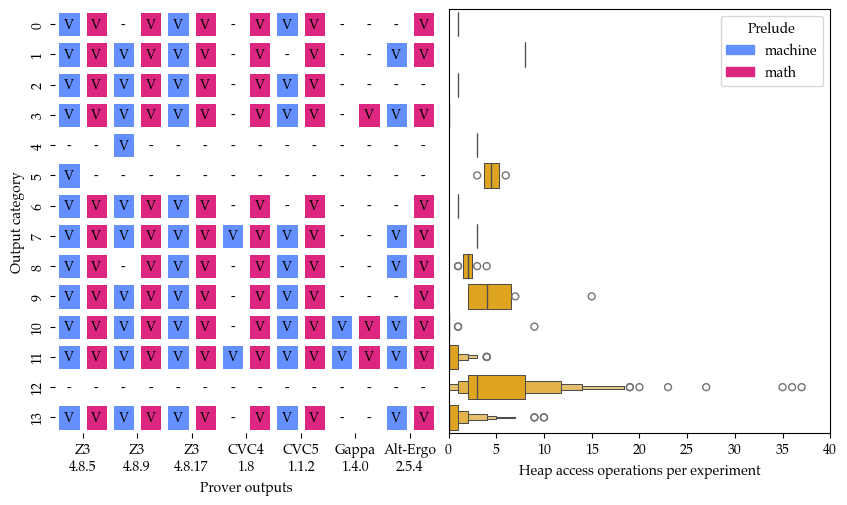

In [23]:
df_stats = df.loc[:, columns + ["heap_count", "missing_inv_count"]].set_index(columns)
df_stats = df_stats.join(df_res_old.reset_index().set_index(columns)).reset_index()

fig, ax = plt.subplots(1, 2, figsize=(10,5.5), gridspec_kw={'wspace': 0.03})
heatmap(ax=ax[0])
sns.boxenplot(data=df_stats, x="heap_count", y="index", orient="h", ax=ax[1], color=palette[2])
ax2 = ax[1]
ax2.set_xlim([0,40])
ax2.get_yaxis().set_visible(False)
ax2.set_xlabel('Heap access operations per experiment')
machine_patch = mpatches.Patch(color=palette[0], label='machine')
math_patch = mpatches.Patch(color=palette[1], label='math')
ax2.legend(handles=[machine_patch, math_patch], loc='upper right', title="Prelude")

plt.tight_layout()
fig.show()
plt.savefig('/Users/maggicl/git/seminar/thesis/figures/06-analysis/heap-by-output.pgf')

/var/folders/84/pwxv9qyd68qfk56f26nwlpgm0000gp/T/ipykernel_2849/1315897759.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/84/pwxv9qyd68qfk56f26nwlpgm0000gp/T/ipykernel_2849/1315897759.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


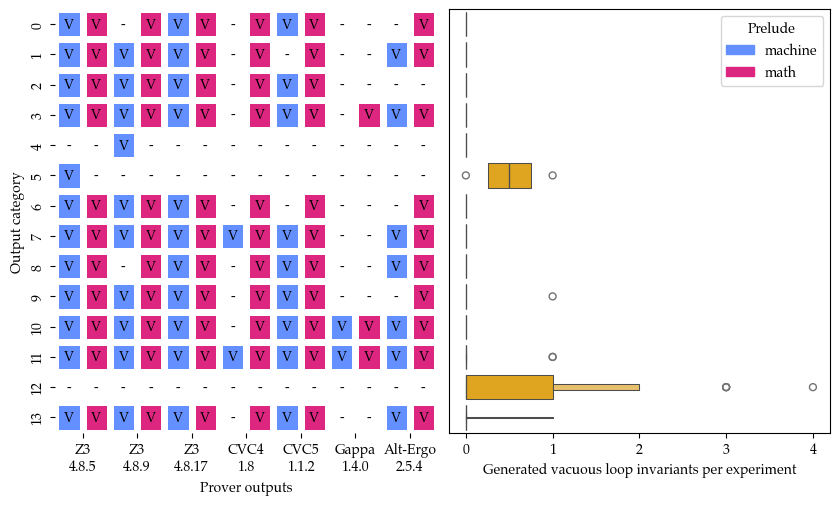

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(10,5.5), gridspec_kw={'wspace': 0.03})
heatmap(ax=ax[0])
sns.boxenplot(data=df_stats, y="index", x="missing_inv_count", orient="h", ax=ax[1], color=palette[2])

ax2 = ax[1]
ax2.get_yaxis().set_visible(False)
ax2.set_xticks(np.arange(0,5,1))
ax2.set_xlabel('Generated vacuous loop invariants per experiment')
machine_patch = mpatches.Patch(color=palette[0], label='machine')
math_patch = mpatches.Patch(color=palette[1], label='math')
ax2.legend(handles=[machine_patch, math_patch], loc='upper right', title="Prelude")
plt.tight_layout()
fig.show()
plt.savefig('/Users/maggicl/git/seminar/thesis/figures/06-analysis/invariants-by-output.pgf')

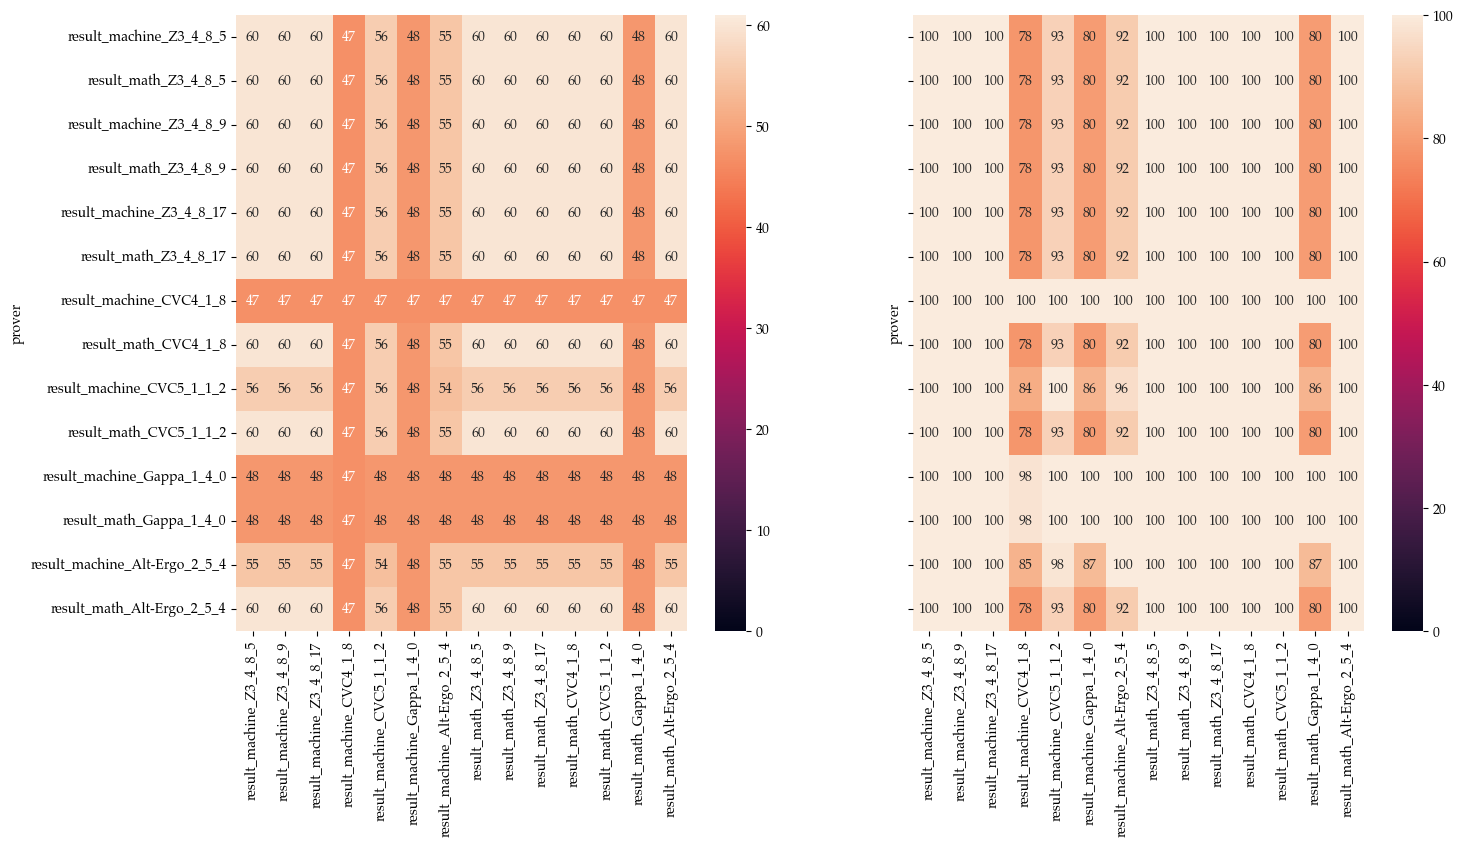

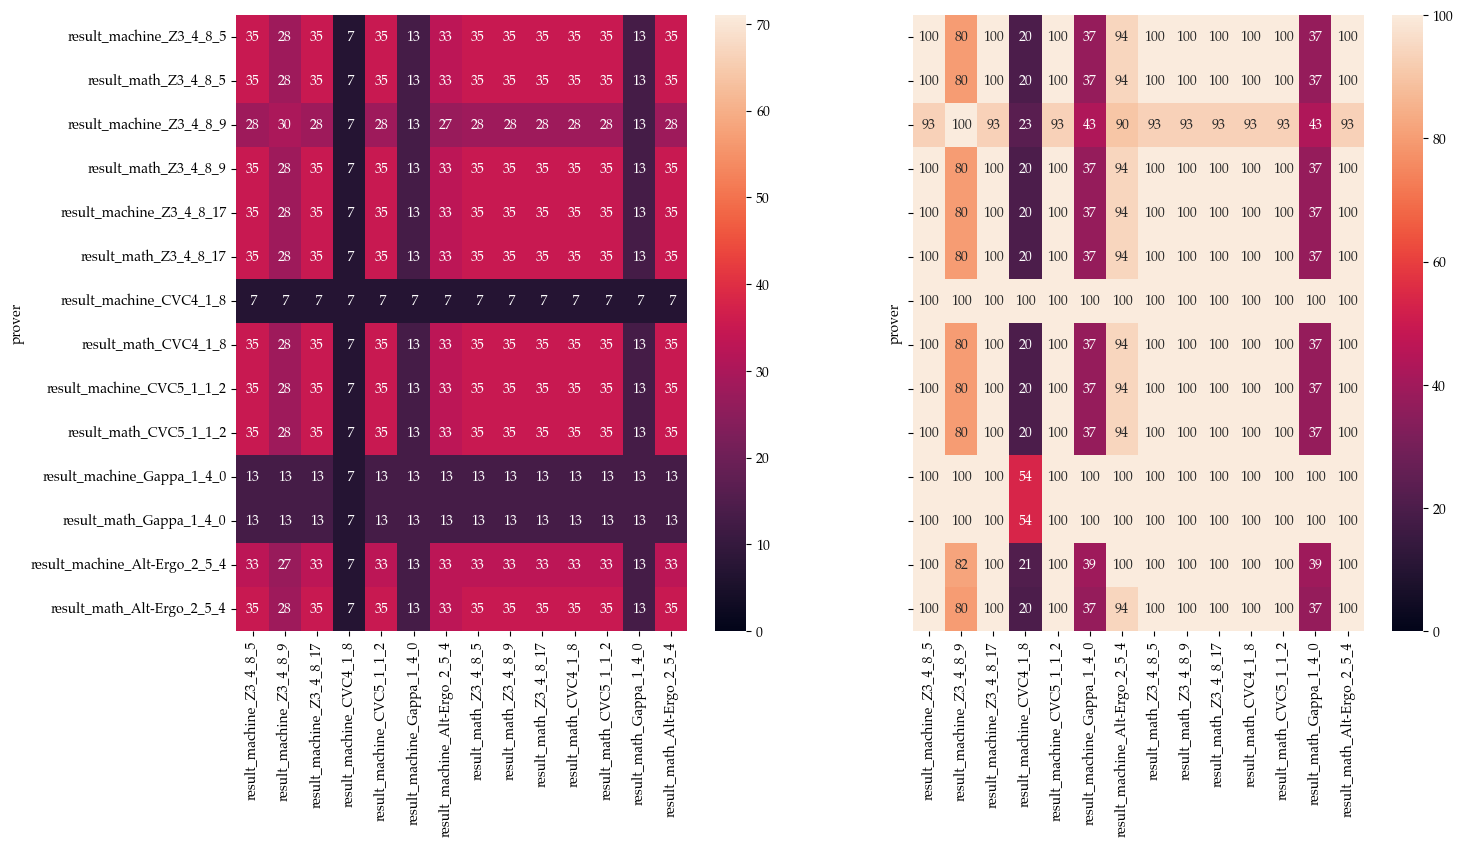

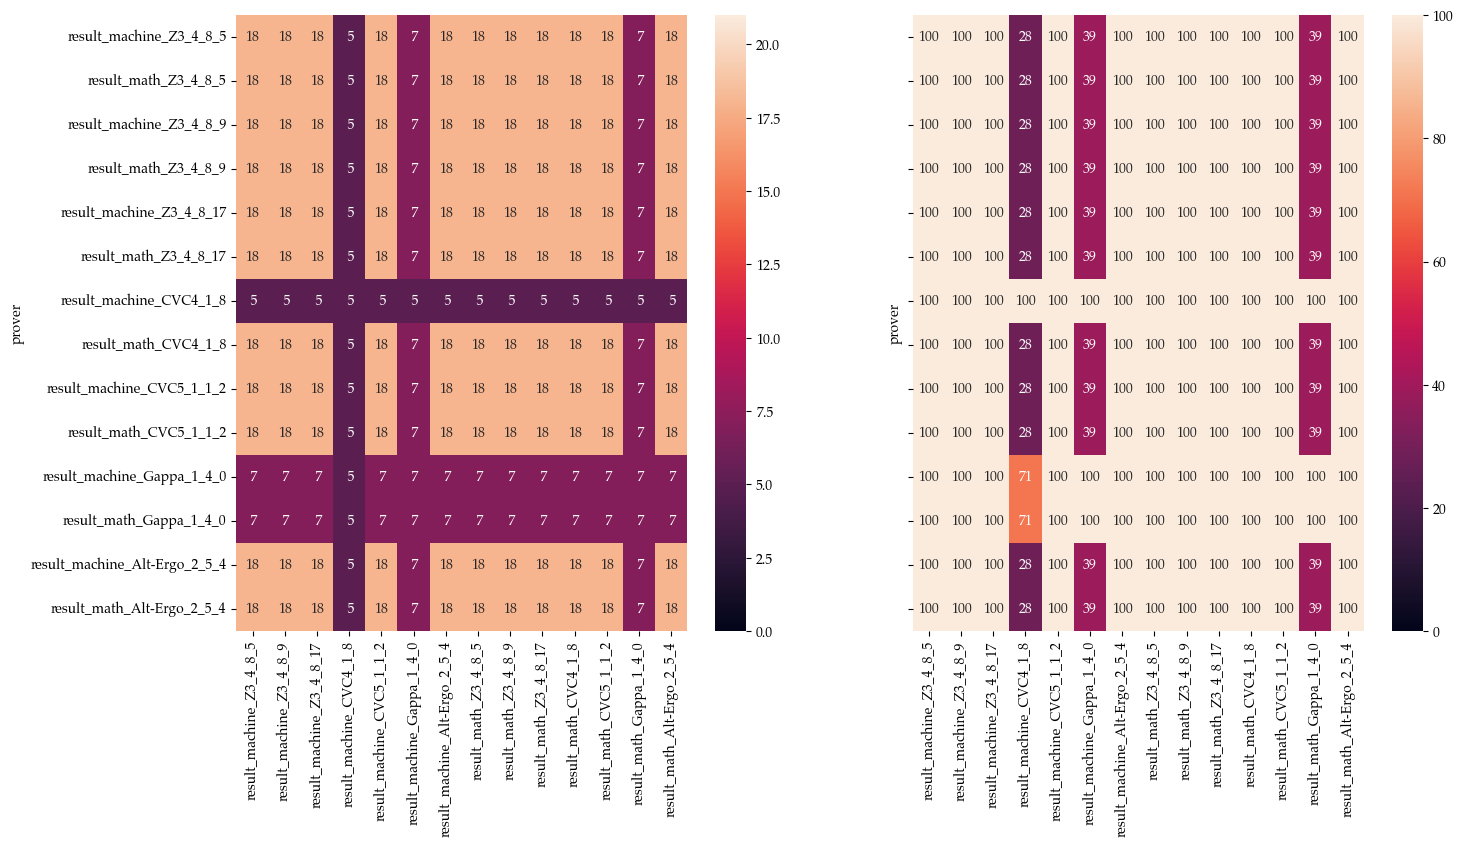

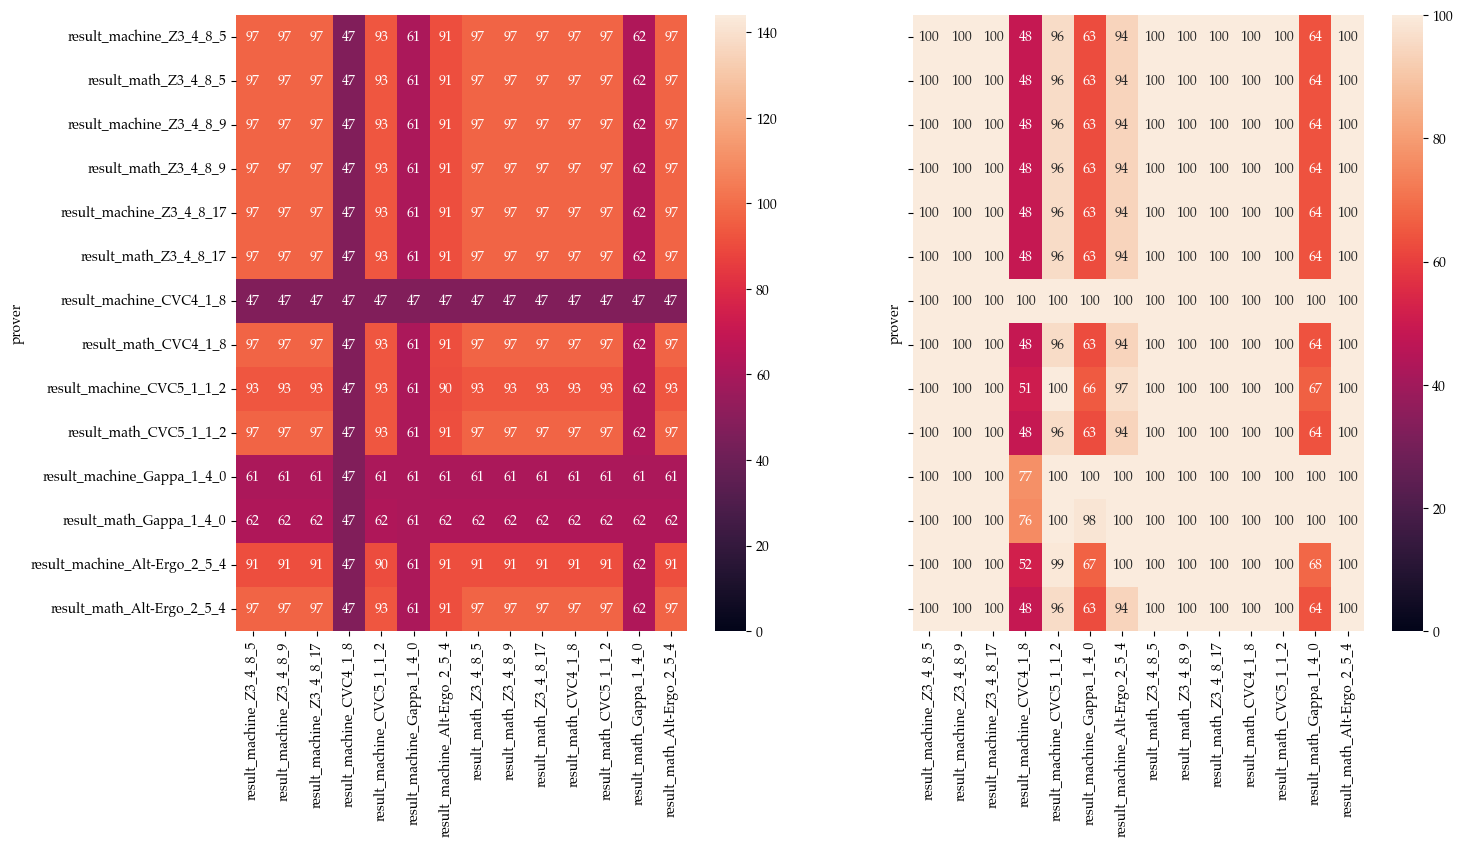

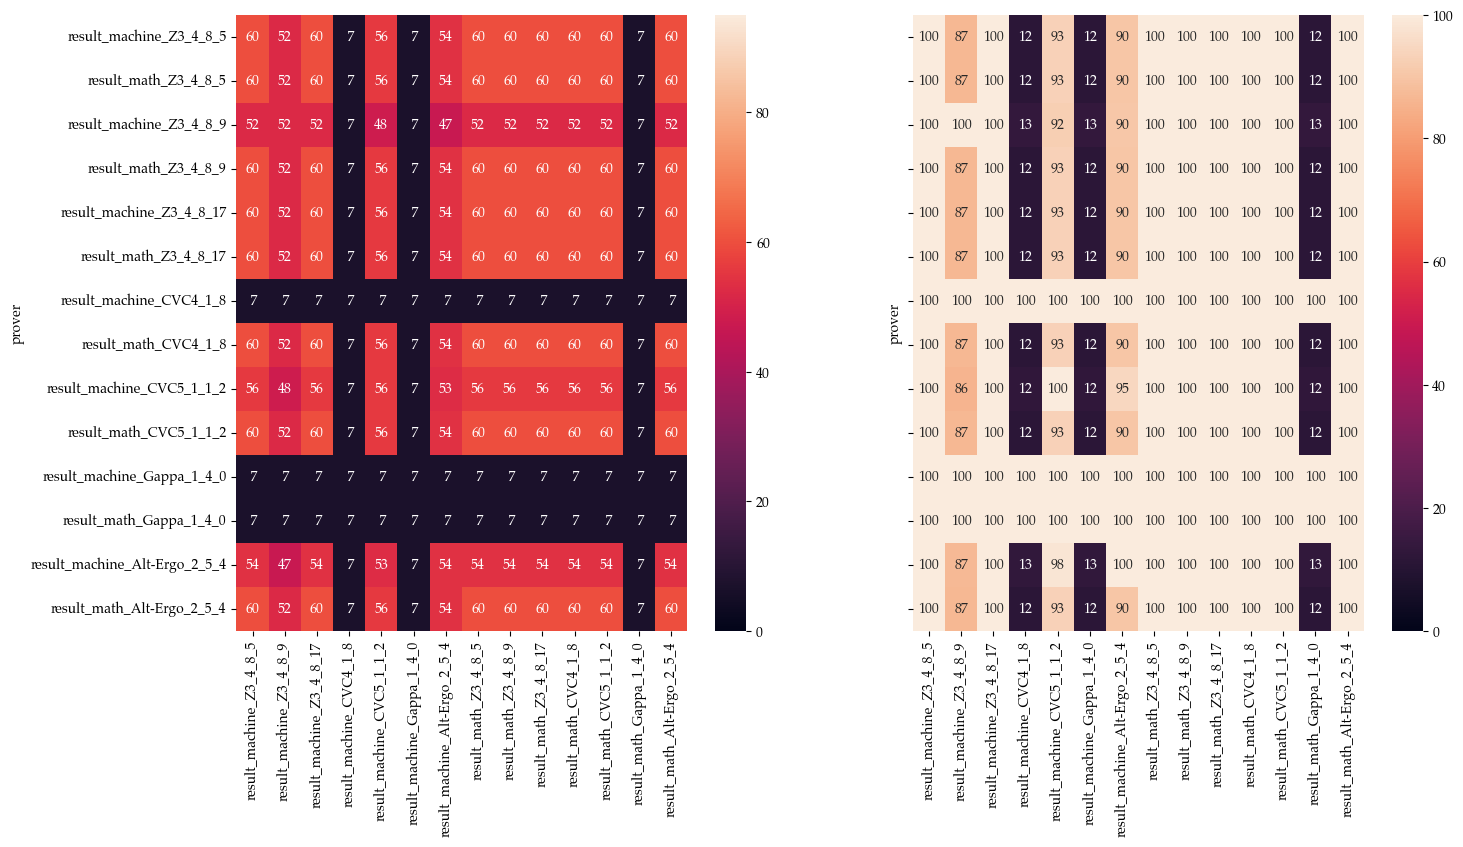

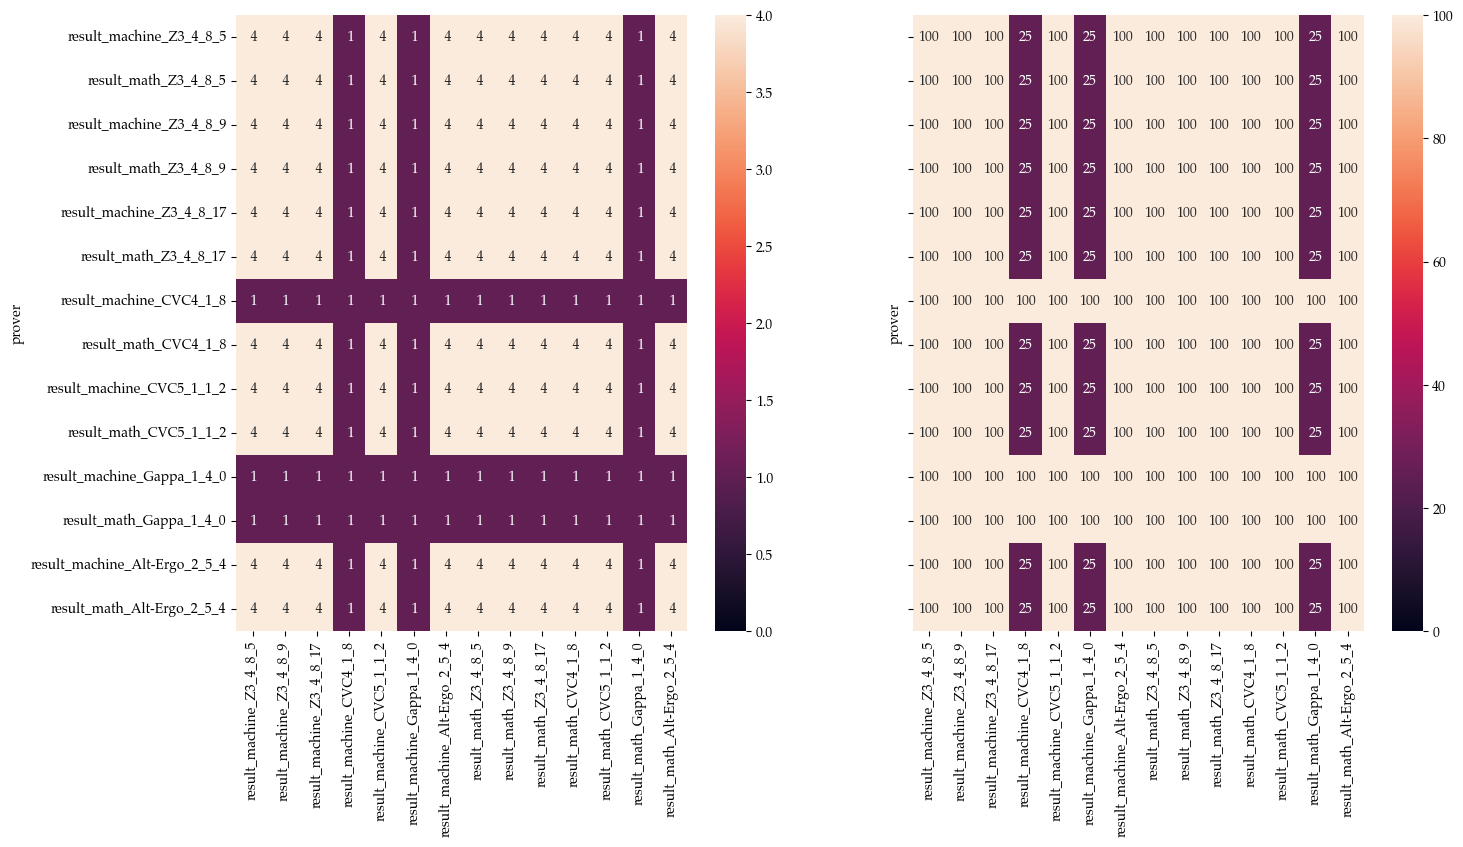

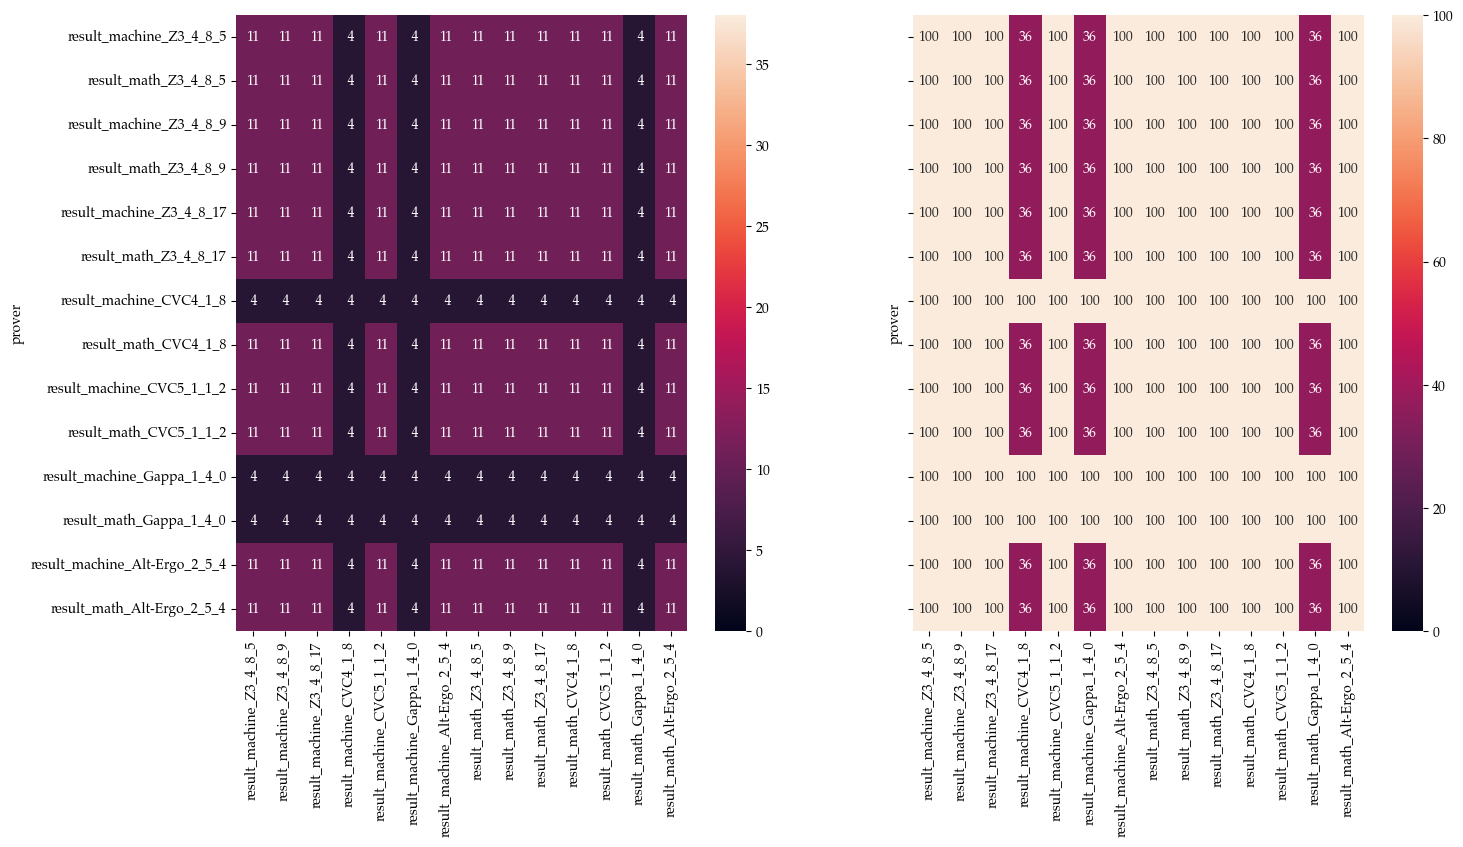

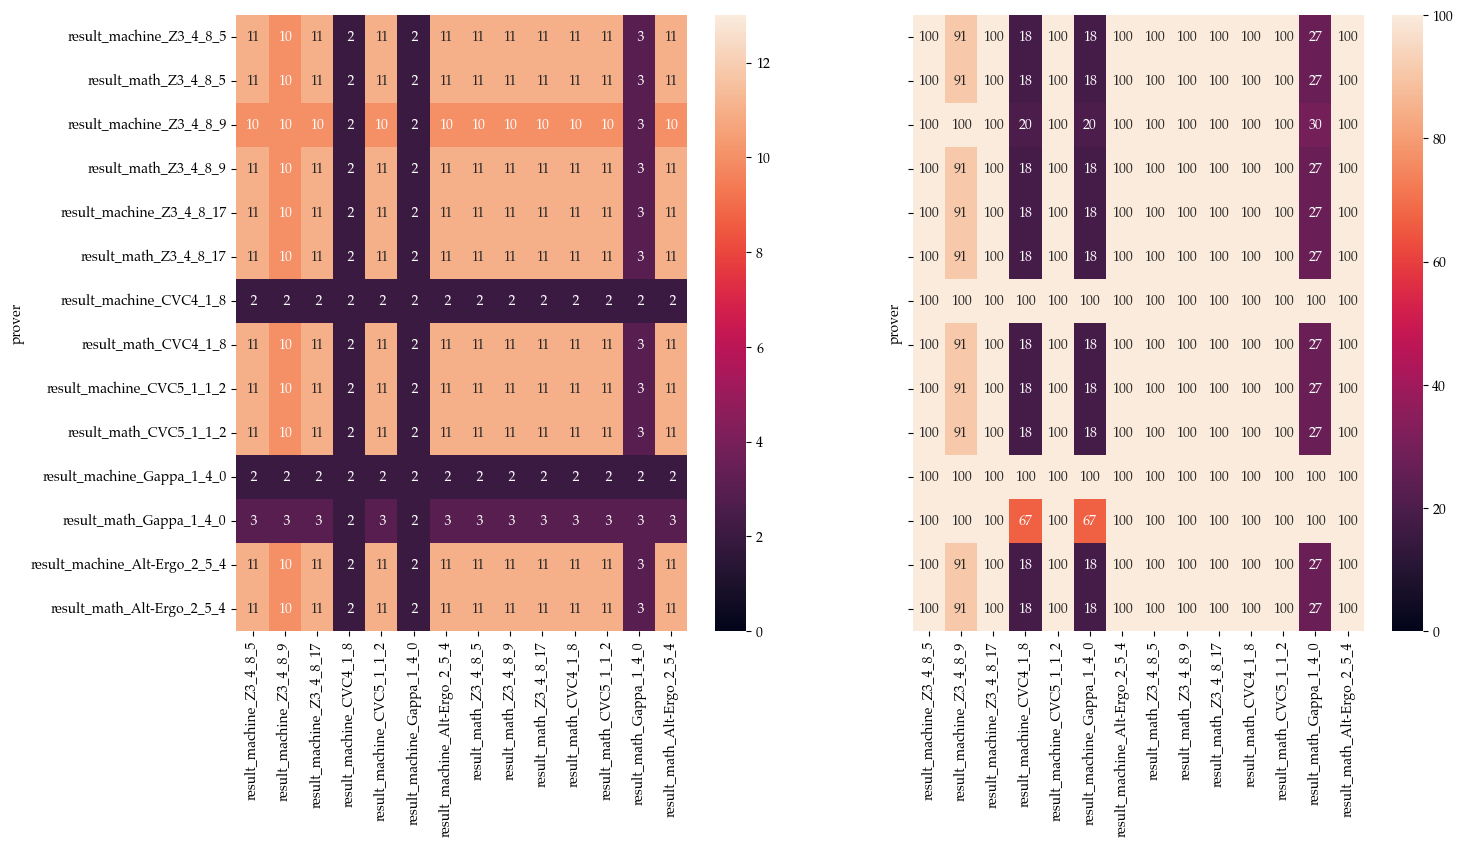

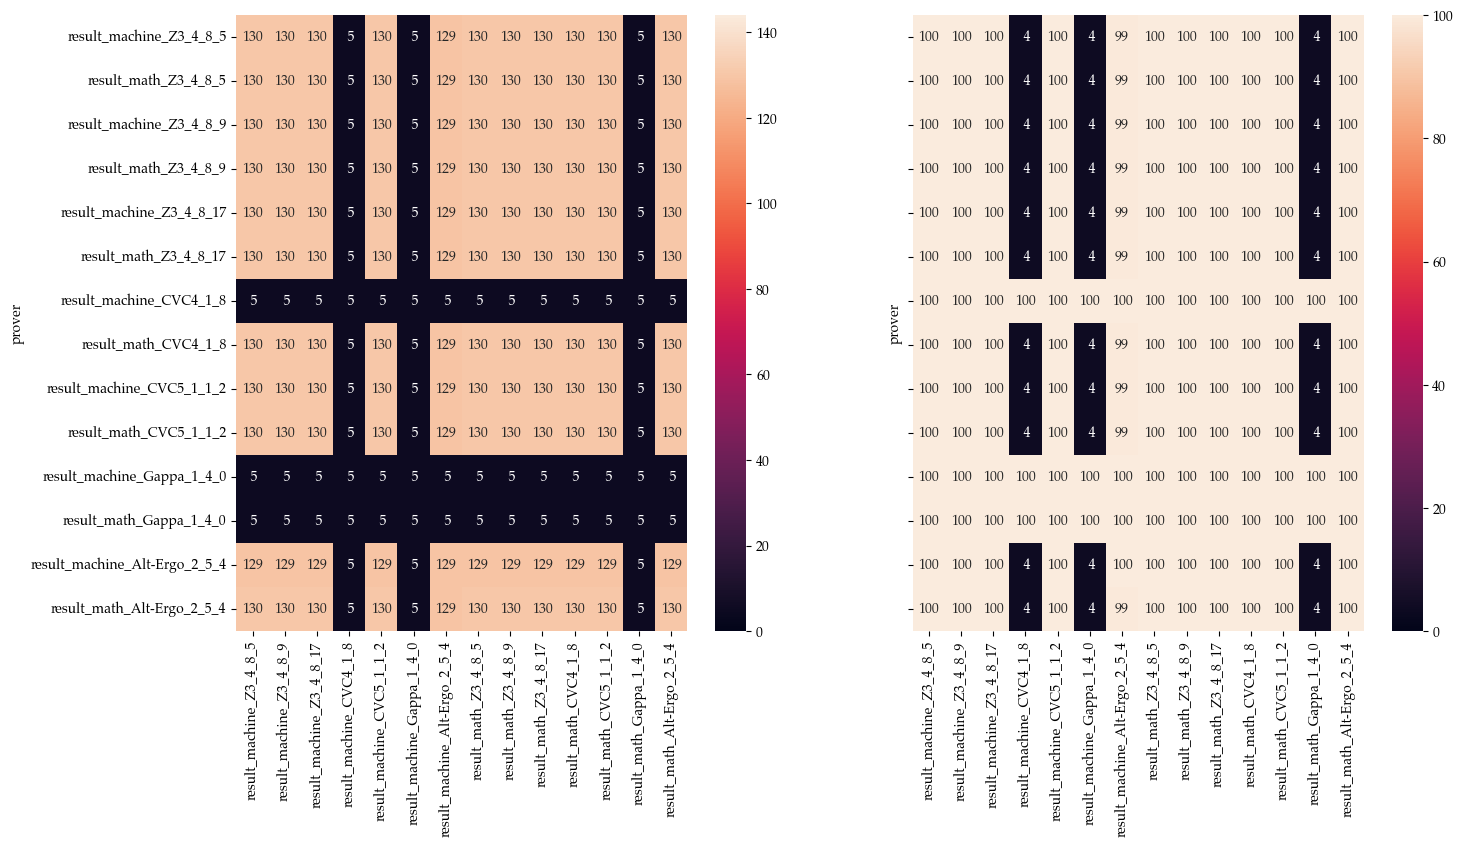

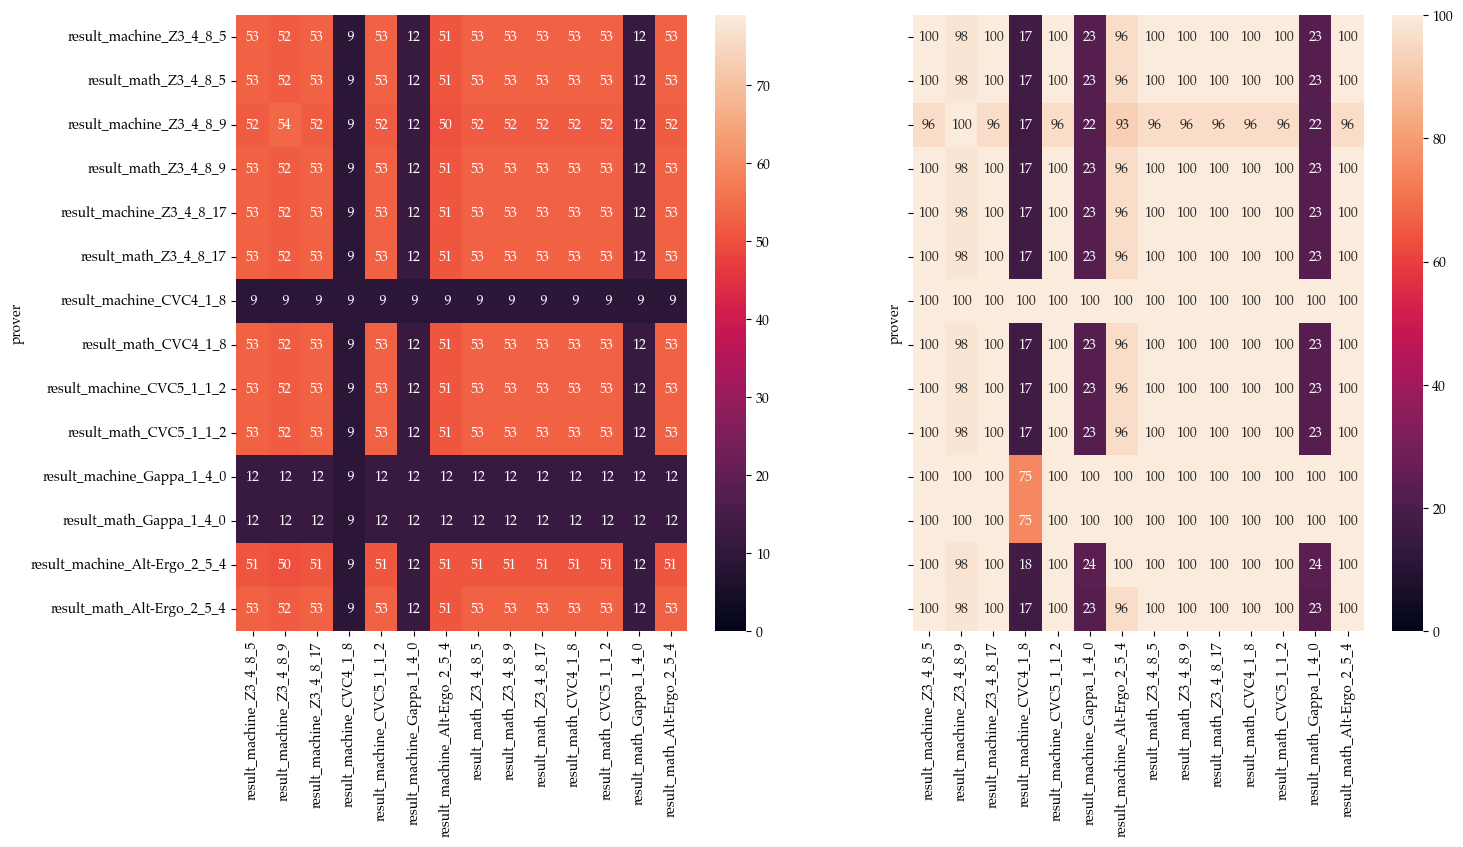

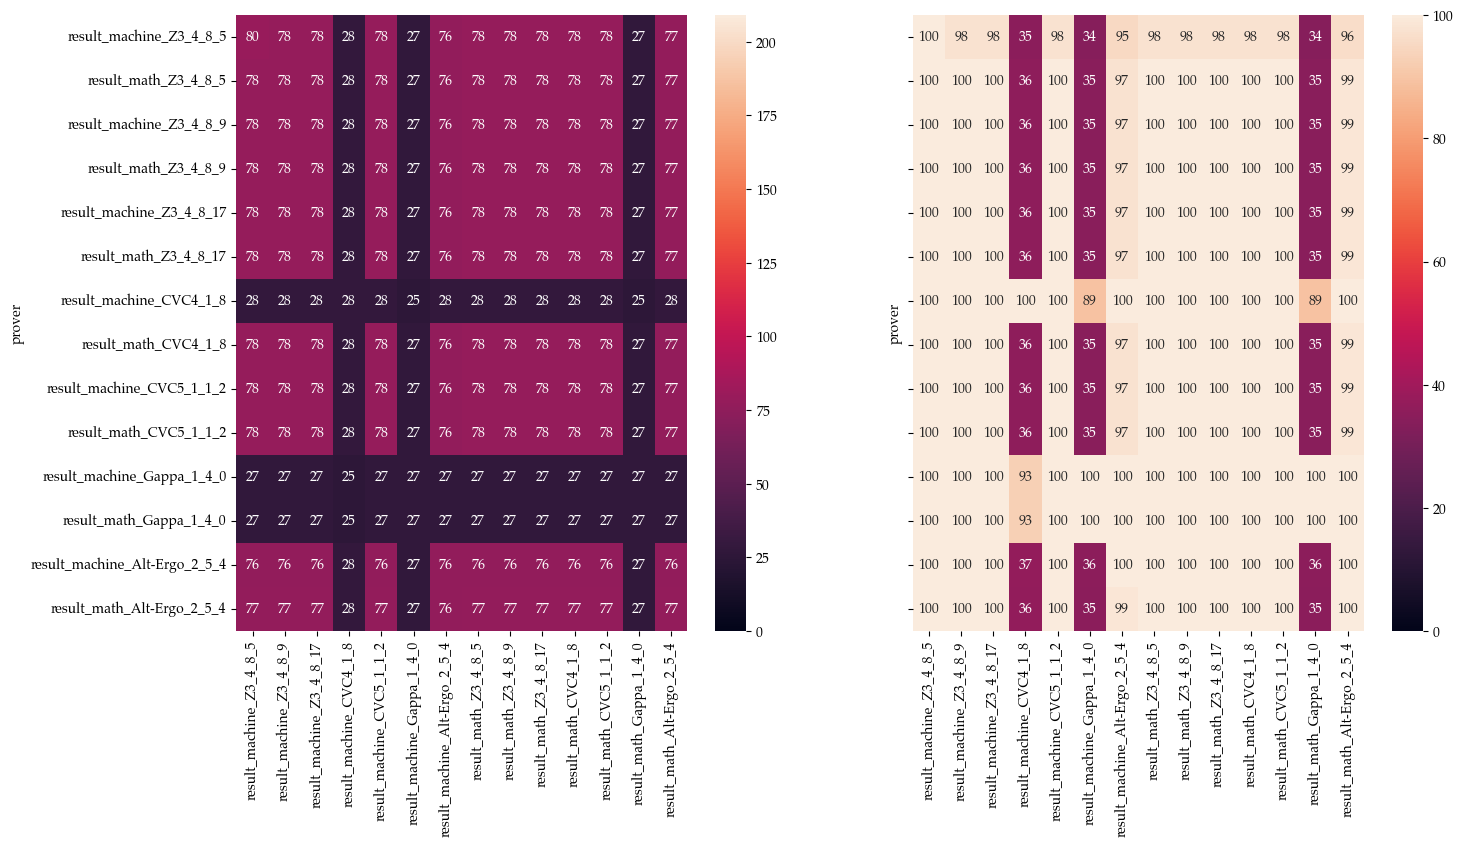

In [11]:
# Number of tests that pass for every prover where they pass
for c in categories:
    # Percentage of tests that pass for every prover where they pass

    df_res_cat = df.loc[of_category(df, c), :].filter(regex=r'^result_').reset_index()
    
    dfs_cat = []
    for column in old_columns:
        if column.startswith("result_"):
            tab = df_res_cat[df_res_cat[column] == 1].copy(deep=True).assign(prover=column).groupby(["prover"]).sum()
            del tab["index"]
            dfs_cat.append(tab)
    df_cat_all = pd.concat(dfs_cat)
    
    display(HTML(f"<hr><h1>{c}</h1>"))

    fig, ax = plt.subplots(1, 2, figsize=(16,8), sharey=True)
    sns.heatmap(df_cat_all, annot=True, fmt="2.0f", ax=ax[0], vmin=0, vmax=len(df_res_cat.index))

    dfs_cat = []
    for column in old_columns:
        if column.startswith("result_"):
            tab = df_res_cat[df_res_cat[column] == 1].copy(deep=True).assign(prover=column)
            count = len(tab.index)
            tab = tab.groupby(["prover"]).sum().apply(lambda r: r.apply(lambda c: 100 * c / count))
            del tab["index"]
            dfs_cat.append(tab)
    df_cat_rel = pd.concat(dfs_cat)

    sns.heatmap(df_cat_rel, annot=True, fmt="2.0f", ax=ax[1], vmin=0, vmax=100)  
    plt.show()

In [12]:
import numpy as np